In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import enchant
from sklearn.feature_extraction.text import CountVectorizer

# Dataset Preparation

In [2]:
true = pd.read_csv('../raw_data/True.csv')
fake = pd.read_csv('../raw_data/Fake.csv')

In [3]:
true.drop(columns = ['subject','date'], inplace = True)
fake.drop(columns = ['subject','date'], inplace = True)

In [4]:
true['score'] = 1
fake['score'] = 0

In [5]:
data = pd.concat([true,fake],ignore_index=True)
data.head()

,title,text,score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Cleaning

In [6]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text

data['title']=data['title'].apply(remove_punctuation)
data['title']=data['title'].apply(remove_numbers)

data['text']=data['text'].apply(remove_punctuation)
data['text']=data['text'].apply(remove_numbers)

In [7]:
def tokenize_text(text):
    return text.split()
data['title_tokens']=data['title'].apply(tokenize_text)
data['tokens']=data['text'].apply(tokenize_text)

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['title_tokens'] = data['title_tokens'].apply(lambda tokens: [token for token in tokens if token not in (stop_words)])
data['tokens'] = data['tokens'].apply(lambda tokens: [token for token in tokens if token not in (stop_words)])

In [9]:
data.head()

,title,text,score,title_tokens,tokens
0,As US budget fight looms Republicans flip thei...,WASHINGTON Reuters The head of a conservative...,1,"[As, US, budget, fight, looms, Republicans, fl...","[WASHINGTON, Reuters, The, head, conservative,..."
1,US military to accept transgender recruits on ...,WASHINGTON Reuters Transgender people will be...,1,"[US, military, accept, transgender, recruits, ...","[WASHINGTON, Reuters, Transgender, people, all..."
2,Senior US Republican senator Let Mr Mueller do...,WASHINGTON Reuters The special counsel invest...,1,"[Senior, US, Republican, senator, Let, Mr, Mue...","[WASHINGTON, Reuters, The, special, counsel, i..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...,1,"[FBI, Russia, probe, helped, Australian, diplo...","[WASHINGTON, Reuters, Trump, campaign, adviser..."
4,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...,1,"[Trump, wants, Postal, Service, charge, much, ...","[SEATTLEWASHINGTON, Reuters, President, Donald..."


In [10]:
english = enchant.DictWithPWL("en_US", "vocab.txt")
wrong_words={}
correct_words=set()
def get_typos_t(tokens):
     wrong_count=0
     for token in tokens:
            if token in wrong_words:
                wrong_words[token]+=1
                wrong_count+=1
            else:
                if not token in correct_words:    
                    if not english.check(token) and not english.check(token.capitalize()):
                        wrong_words[token]=1
                        wrong_count+=1
                    else:
                        correct_words.add(token)
     return wrong_count       

# Keep Cleaning

In [11]:
data['token_count']=data['tokens'].apply(lambda tokens:len(tokens))

In [12]:
data['wrong_tokens_count']=data['tokens'].apply(get_typos_t)

In [13]:
data['typo_ratio']= data['wrong_tokens_count']/data['token_count']


<AxesSubplot:xlabel='score', ylabel='typo_ratio'>

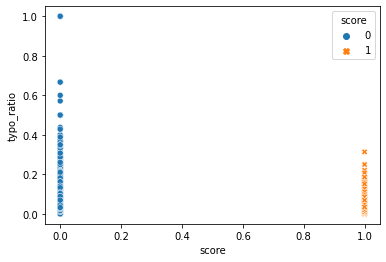

In [14]:
sns.scatterplot(data=data, x="score", y="typo_ratio", hue="score", style="score")

In [15]:
data.columns

Index(['title', 'text', 'score', 'tokens', 'token_count', 'wrong_tokens_count',
       'typo_ratio'],
      dtype='object')

In [16]:
data_clean = data[['title', 'text', 'typo_ratio','score']].copy()

In [17]:
data_clean.shape

(44898, 4)

# Log Regression

In [18]:
#feature_cols = ['text', 'typo_ratio']
#x=data_clean[feature_cols]
y=data['score']

In [19]:
feature_cols = ['text','typo_ratio']

#x=data_clean[feature_cols]
x=data_clean[['text','typo_ratio']]

In [20]:
x.shape

(44898, 2)

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.3)

In [22]:
x_train

,text,typo_ratio
33958,This latest Wikileaks email evidence smoke Hil...,0.053492
19813,BERLIN Reuters Germany Free Democrats FDP woul...,0.068259
25814,Trump bad week First humiliated front millions...,0.029810
18689,TALLINN Reuters French President Emmanuel Macr...,0.032129
44673,Do roses know thorns hurt quote attributed Jon...,0.044799
22749,Earlier month sinkhole opened outside Donald T...,0.150442
2628,WASHINGTON Reuters The cofounder firm commissi...,0.050633
10117,WASHINGTON Reuters US Vice President Joe Biden...,0.042857
4388,BRUSSELS Reuters European Council President Do...,0.037037
16056,TOKYO Reuters A tunnel North Korea nuclear tes...,0.022556


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
preprocessor = ColumnTransformer([
    ('vectorizer_text', CountVectorizer(), 'text'),

])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('Logistic', LogisticRegression())])

In [24]:

# #from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# vectorizer = CountVectorizer()
# #vectorizer_T = TfidfVectorizer()
# #x_vec = vectorizer.fit_transform(x_train)
# x_train_vec = vectorizer.fit_transform(x_train['text'])

In [25]:
final_pipe.fit(x_train,y_train)

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('vectorizer_text', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', i...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [26]:
final_pipe.score(x_test,y_test)

0.9968819599109131

In [27]:
y_test.shape

(13470,)

In [28]:
# x_train_vec=pd.DataFrame(x_train_vec)
# #x_vec=x_train_vec+x_train['typo_ratio']

In [29]:
# x_vec=x_train_vec+x_train['typo_ratio']

In [30]:
# model=LogisticRegression()

In [31]:
# x_vec.shape

In [32]:
# print(x_vec)

In [33]:
# y_train.shape

In [34]:
# model.fit(x_vec,y_train)

In [35]:
pred=model.predict(vectorizer.transform(x_test))

NameError: name 'model' is not defined

In [ ]:
score=accuracy_score(y_test,pred)
score

# Word_tokenizer

In [ ]:
#data['tokens_tweet']= data['text'].apply(tknzr)

In [ ]:
from nltk.tokenize import word_tokenize
data['tokens_tweet']=data['text'].apply(word_tokenize)

In [ ]:
data.head()